In [3]:
# ======================================================================================================
# 
# ------------------------------------------ Starting HERE ---------------------------------------------
# 
# ======================================================================================================

import carla
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [4]:
# Get access to the client and the world
client = carla.Client('localhost', 2000)
world = client.get_world()
world.unload_map_layer(carla.MapLayer.All)

In [6]:
# Define the type of car we want to use
vehicle_blueprint = client.get_world().get_blueprint_library().filter('model3')[0]

In [125]:
# ====================================
# -- SPAWN VEHICLE -------------------
# ====================================
spawn_point = client.get_world().get_map().get_spawn_points()[85]
vehicle = client.get_world().spawn_actor(vehicle_blueprint, spawn_point)

In [8]:
# Add RGB camera
camera_bp = client.get_world().get_blueprint_library().find('sensor.camera.rgb')
camera_init_trans = carla.Transform(carla.Location(x=-0.1, z=1.7))
camera = world.spawn_actor(camera_bp, camera_init_trans, attach_to=vehicle)
camera.sensor_tick = 0.05

In [9]:
# set spectator to be on the car's dash
spectator = world.get_spectator()
spec_transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-4, z=2.5)), vehicle.get_transform().rotation)
spectator.set_transform(spec_transform)

In [48]:
# Define our PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.integral = 0
        self.previous_error = 0

    def update(self, error, delta_time):
        self.integral += error * delta_time
        derivative = (error - self.previous_error) / delta_time
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.previous_error = error
        return output

In [126]:
# Define the perturbation from spawn
perturb_vehicle = carla.VehicleControl()
perturb_vehicle.steer = 0.9
perturb_vehicle.throttle = 0.25

stop_vehicle_control = carla.VehicleControl()
stop_vehicle_control.steer = 0.9
stop_vehicle_control.brake = 0.5

# Apply the perturbation
vehicle.apply_control(perturb_vehicle)
time.sleep(2)
vehicle.apply_control(stop_vehicle_control)

In [127]:
desired_y_position = 28.1  # The y-coordinate of the desired line
lateral_error_threshold = 0.1  # Threshold for switching to heading control
desired_heading = 0  # Desired heading in degrees
delta_time = 0.01

# Initialize PID controllers
pid_heading = PIDController(Kp=0.1, Ki=0.001, Kd=0.01)  # For heading control
pid_lateral = PIDController(Kp=0.8, Ki=0.05, Kd=0.05)  # For lateral control

lateral_errors = []
heading_errors = []
timestamps = []

# Start camera
camera.listen(lambda image: image.save_to_disk('out/%86d.png' % image.frame))

time_start = time.time()
for i in range(2500):
    if i % 1000 == 0:
        print(f'Iteration: {i}')
    # Get current vehicle position and heading
    vehicle_transform = vehicle.get_transform()
    vehicle_location = vehicle_transform.location
    vehicle_rotation = vehicle_transform.rotation.yaw

    # Calculate lateral error
    lateral_error = desired_y_position - vehicle_location.y
    
    heading_correction = pid_lateral.update(lateral_error, delta_time)
    
    # Calculate heading error
    heading_error = desired_heading - vehicle_rotation
    heading_error = (heading_error + 180) % 360 - 180
    
    if not (abs(lateral_error) > lateral_error_threshold):
        heading_correction = pid_heading.update(heading_error, delta_time)
        
    # Apply control
    control = carla.VehicleControl()
    control.steer = max(min(heading_correction, 1.0), -1.0)
    control.throttle = 0.3
    
    # record for matplotlib
    timestamps.append(time.time() - time_start)
    lateral_errors.append(lateral_error)
    heading_errors.append(heading_error)
    
    vehicle.apply_control(control)

    # Wait for next control cycle
    time.sleep(delta_time)

print('Done!')
camera.stop()

Iteration: 0
Iteration: 1000
Iteration: 2000
Done!


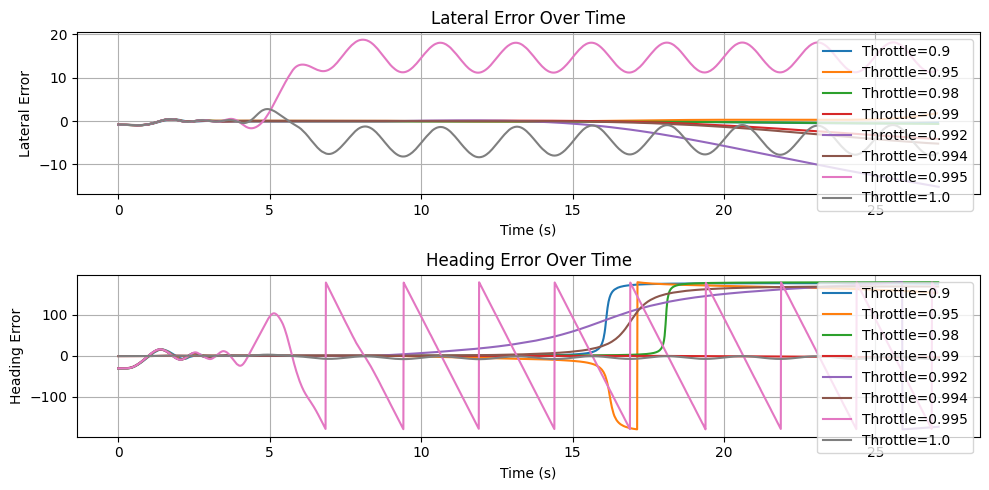

In [131]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(timestamps, lateral_errors, label='Throttle=0.3')
plt.xlabel('Time (s)')
plt.ylabel('Lateral Error')
plt.title('Lateral Error Over Time')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(timestamps, heading_errors, label='Throttle=0.3')
plt.xlabel('Time (s)')
plt.ylabel('Heading Error')
plt.title('Heading Error Over Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('lateral-heading-error.png')
plt.show()

In [128]:
# for clean-up
vehicle.destroy()

if camera:
    camera.destroy()

False

In [5]:
# ======================================================================================================
# 
# ------------------------------ Additional helper methods ---------------------------------------------
#
# ======================================================================================================
# waypoints are from 0-220 incrementing by 4; each waypoint is +1 in the x location

def draw_waypoints(waypoints, road_id=None, life_time=50.0):
    for waypoint in waypoints:
        # if we only want to draw waypoints on a specific road
        if road_id:
            if waypoint.road_id == road_id:
                world.debug.draw_string(waypoint.transform.location, f'{waypoint.road_id}', draw_shadow=False,color=carla.Color(r=0, g=255, b=0), life_time=life_time, persistent_lines=True)
        # draw all waypoints
        else:
            world.debug.draw_string(waypoint.transform.location, 'O', draw_shadow=False,color=carla.Color(r=0, g=255, b=0), life_time=life_time, persistent_lines=True)
            
# examples usage:
waypoints = client.get_world().get_map().generate_waypoints(distance=1.0)
draw_waypoints(waypoints, road_id=None, life_time=20)

In [10]:
# filter waypoints by road_id and provide specific indexing for them for access
filtered_waypoints = []
for waypoint in waypoints:
    if waypoint.road_id == 20:
        filtered_waypoints.append(waypoint)
        
for i, sp in enumerate(filtered_waypoints):
    world.debug.draw_string(sp.transform.location, str(i), draw_shadow=False, color=carla.Color(r=0, g=255, b=0), life_time=20, persistent_lines=True)

In [ ]:
# show spawn points
test_spawn = client.get_world().get_map().get_spawn_points()

for i, sp in enumerate(test_spawn):
    world.debug.draw_string(sp.location, str(i), draw_shadow=False, color=carla.Color(r=255,g=0,b=0), life_time=20, persistent_lines=True)

In [ ]:
# Compile the images into a video
import os

image_folder = 'out'
video_name = 'testing_video_lowfps.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# video name, fourcc, fps, tuple of dimensions
video = cv2.VideoWriter(video_name, 0, 10, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()
